<div align="center">

#

### **NLP Disaster Tweets Kaggle Mini-Project**

<br>

**Sepideh Forouzi**

</div>




## **1. Introduction**

In this project, my objective is to build a machine learning model that can automatically determine whether a tweet refers to a real disaster or not. Social media platforms such as Twitter generate large volumes of short, informal messages, and during emergency situations it becomes extremely valuable to distinguish factual disaster reports from jokes, figurative expressions, or unrelated uses of disaster-related terms. Developing an automated classifier for this task can support real-time monitoring and help organizations respond quickly to emerging events.

The dataset used in this work comes from the Kaggle competition **“Natural Language Processing with Disaster Tweets.”** It includes:

- **7,613 labeled training tweets**
- **3,263 unlabeled test tweets**

Each tweet contains short text along with optional metadata such as keywords and location fields. The target label indicates whether a tweet genuinely describes a disaster (`1`) or not (`0`).  
Dataset source: https://www.kaggle.com/competitions/nlp-getting-started/data

To address the classification task, I performed exploratory data analysis, text cleaning, and a systematic comparison of two modeling strategies:

1. **TF–IDF + Logistic Regression baseline**  
2. **Bidirectional LSTM (BiLSTM)** neural network

Both models were trained and evaluated using accuracy, F1 score, and confusion matrices.

The main goal of this project is not only to achieve strong predictive performance but also to understand the differences between classical text-representation methods (hand-engineered TF–IDF n-grams) and learned neural representations (BiLSTM embeddings). By comparing the two approaches, I aim to highlight their strengths, limitations, and suitability for real-world disaster-related tweet classification.



---
### **1 — Upload and Load the Dataset**

In this step, I manually upload the three required files from my local device into Google Colab:

- **train.csv** — labeled tweets used for model training  
- **test.csv** — unlabeled tweets for Kaggle submission  
- **sample_submission.csv** — submission template provided by Kaggle  

After uploading, I load the CSV files into Pandas dataframes to begin the analysis. This cell initializes the dataset and confirms that the files were imported correctly by printing their shapes and displaying the first few rows of the training set.


In [1]:
# === Cell 1: Upload train.csv, test.csv, sample_submission.csv from your device ===

from google.colab import files
uploaded = files.upload()

# The uploaded files will appear in the Colab working directory.
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv
Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **2A — Missing Values Analysis**

Before performing any text preprocessing or model training, I first examine the dataset for missing values. Identifying missing entries is an essential preprocessing step because empty fields in the `text`, `keyword`, or `location` columns may affect feature extraction and model performance.

In this cell, I compute both:
- the **absolute number of missing values** for each column, and  
- the **percentage of missing values** relative to the entire dataset.

I then combine these results into a summary table, sort the columns by the number of missing entries, and apply a styled gradient to make the distribution of missing data easy to interpret. This helps me understand the quality of the dataset and informs decisions about dropping, imputing, or ignoring specific fields during modeling.


In [9]:
# === Cell 2A: Missing Values Table (sorted & styled) =============================

import pandas as pd

missing_count = train.isna().sum().rename("missing")
missing_pct   = (train.isna().mean() * 100).rename("missing_%")

summary = pd.concat([missing_count, missing_pct], axis=1).sort_values("missing", ascending=False)

styled_summary = summary.style.format({"missing_%": "{:.2f}%"}).background_gradient(cmap="Blues")
styled_summary


,missing,missing_%
location,2533,33.27%
keyword,61,0.80%
id,0,0.00%
text,0,0.00%
target,0,0.00%
text_length,0,0.00%
text_clean,0,0.00%
text_len_words,0,0.00%


### **2B — Preprocessing: Target Class Distribution**

As part of the preprocessing stage, I analyzed the distribution of the target variable, which indicated whether each tweet described a real disaster (`1`) or a non-disaster (`0`). Understanding this distribution was an important step because the balance between the two classes directly influenced model behavior during training and evaluation.

In this cell, I calculated the frequency of each target class, computed the percentage contribution for both classes, and visualized the results using a color-coded bar plot. This analysis allowed me to confirm whether the dataset was balanced or imbalanced and helped inform later decisions regarding model training and evaluation strategies.


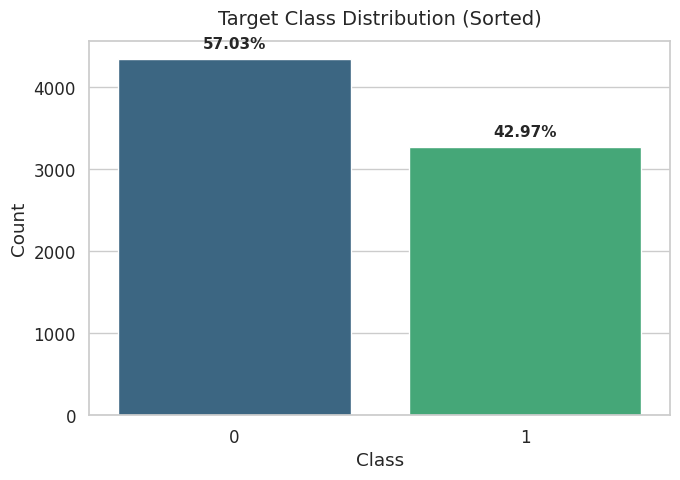

In [10]:
# === Cell 2B: Target Distribution Plot (sorted + % labels + colorful) ============

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Ensure column exists
if "target" not in train.columns:
    print("No 'target' column found — skipping target distribution plot.")
else:
    counts = train["target"].value_counts().sort_values(ascending=False)
    pct    = (counts / counts.sum() * 100).round(2)

    plt.figure(figsize=(7,5))
    palette = sns.color_palette("viridis", len(counts))

    ax = sns.barplot(
        x=counts.index.astype(str),
        y=counts.values,
        palette=palette
    )

    # Add % labels above bars
    for i, (cls, val) in enumerate(counts.items()):
        ax.text(i, val + max(counts.values)*0.02, f"{pct[cls]}%",
                ha="center", va="bottom", fontsize=11, fontweight="bold")

    ax.set_title("Target Class Distribution (Sorted)", pad=12, fontsize=14)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()


### **2C — Text Normalization (URLs, Mentions, Hashtags, Numbers, Elongations)**

To prepare the tweets for modeling, I applied a custom text-normalization function that standardizes noisy patterns commonly found in social media.  
This step reduces variability, improves token consistency, and strengthens both TF–IDF and neural sequence models.

The normalization pipeline performs the following transformations:

- Converts HTML entities and text to lowercase  
- Replaces URLs with the token `<url>`  
- Replaces user mentions with `<user>`  
- Splits hashtags into the marker `<hashtag>` followed by the keyword  
- Replaces standalone numbers with `<num>`  
- Reduces character elongation (e.g., *soooo* → *soo*)  
- Adds spacing around punctuation and collapses multiple spaces  

After defining the function, I apply it once to the entire dataset to create a new column named **`text_clean`**, which becomes the primary text field for all downstream models.


In [50]:
# === Cell 2c: Text normalization (URLs, mentions, hashtags, emojis, elongations) ===
import re
import html

def normalize_tweet(s: str) -> str:
    s = html.unescape(s)
    s = s.lower()
    # urls → <url>
    s = re.sub(r'https?://\S+|www\.\S+', ' <url> ', s)
    # @mentions → <user>
    s = re.sub(r'@\w+', ' <user> ', s)
    # hashtags: split words if possible, keep marker
    s = re.sub(r'#([A-Za-z0-9_]+)', r' <hashtag> \1 ', s)
    # numbers → <num>
    s = re.sub(r'\b\d+\b', ' <num> ', s)
    # repeated letters “sooo” → “soo” (cap at 2)
    s = re.sub(r'(.)\1{2,}', r'\1\1', s)
    # punctuation spacing
    s = re.sub(r'([!?.,:/();\-"])', r' \1 ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply once and reuse everywhere
train["text_clean"] = train["text"].fillna("").astype(str).map(normalize_tweet)
print("✓ Text normalization complete. Column 'text_clean' created.")



✓ Text normalization complete. Column 'text_clean' created.


### **2D — Preview Original vs. Cleaned Tweets (Quality Check)**

To verify that normalization behaved as intended, I compare the **raw** and **cleaned** text side-by-side and include simple length diagnostics:

- **`len_raw`**: number of characters in the original tweet  
- **`len_clean`**: number of characters after normalization  
- **`delta_len`**: difference `len_raw − len_clean` (helps spot aggressive trimming)

I present two styled tables:

1. **First 10 rows** — a deterministic preview to confirm consistent behavior.  
2. **Random sample (n=8)** — a spot check to catch edge cases (URLs, mentions, hashtags, elongations).

The colored backgrounds highlight magnitude differences in lengths, making it easy to detect anomalies (e.g., excessive shortening or unexpected growth). This step serves as a fast **sanity check** before feature extraction and model training.


In [51]:
# === Cell 2D: Preview original vs. cleaned tweets (styled) =======================
import pandas as pd
from IPython.display import display

# Safety: ensure Cell 2C ran
assert "text_clean" in train.columns, "Run Cell 2C first to create 'text_clean'."

# First 10 rows — show original vs cleaned + simple length diagnostics
head_df = (
    train[["text", "text_clean"]]
    .head(10)
    .assign(
        len_raw=lambda d: d["text"].fillna("").astype(str).str.len(),
        len_clean=lambda d: d["text_clean"].astype(str).str.len(),
        delta_len=lambda d: d["text"].fillna("").astype(str).str.len()
                   - d["text_clean"].astype(str).str.len()
    )
)
styled_head = (
    head_df
    .style
    .set_caption("Original vs. Cleaned — First 10 Rows")
    .format({"len_raw":"{:d}", "len_clean":"{:d}", "delta_len":"{:+d}"})
    .background_gradient(cmap="Blues", subset=["len_raw","len_clean","delta_len"])
)

# Random sample — quick spot check
sample_df = (
    train.sample(8, random_state=42)[["text", "text_clean"]]
    .assign(
        len_raw=lambda d: d["text"].fillna("").astype(str).str.len(),
        len_clean=lambda d: d["text_clean"].astype(str).str.len(),
        delta_len=lambda d: d["text"].fillna("").astype(str).str.len()
                   - d["text_clean"].astype(str).str.len()
    )
)
styled_sample = (
    sample_df
    .style
    .set_caption("Original vs. Cleaned — Random Sample (n=8)")
    .format({"len_raw":"{:d}", "len_clean":"{:d}", "delta_len":"{:+d}"})
    .background_gradient(cmap="Purples", subset=["len_raw","len_clean","delta_len"])
)

display(styled_head)
display(styled_sample)


,text,text_clean,len_raw,len_clean,delta_len
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,our deeds are the reason of this earthquake may allah forgive us all,69,78,-9
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask . canada,38,39,-1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,all residents asked to 'shelter in place' are being notified by officers . no other evacuation or shelter in place orders are expected,133,134,-1
3,"13,000 people receive #wildfires evacuation orders in California",", people receive wildfires evacuation orders in california",65,80,-15
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,88,105,-17
5,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,rockyfire update => california hwy . closed in both directions due to lake county fire - cafire wildfires,110,141,-31
6,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas","flood disaster heavy rain causes flash flooding of streets in manitou , colorado springs areas",95,114,-19
7,I'm on top of the hill and I can see a fire in the woods...,i'm on top of the hill and i can see a fire in the woods . .,59,60,-1
8,There's an emergency evacuation happening now in the building across the street,there's an emergency evacuation happening now in the building across the street,79,79,+0
9,I'm afraid that the tornado is coming to our area...,i'm afraid that the tornado is coming to our area . .,52,53,-1


,text,text_clean,len_raw,len_clean,delta_len
2644,So you have a new weapon that can cause un-imaginable destruction.,so you have a new weapon that can cause un - imaginable destruction .,66,69,-3
2227,The f$&@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,the f$& things i do for gishwhes just got soaked in a deluge going for pads and tampons . thx @ / @,119,123,-4
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,dt : rt : ûïthe col police can catch a pickpocket in liverpool stree . .,125,93,+32
132,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,aftershock back to school kick off was great . i want to thank everyone for making it possible . what a great night .,114,117,-3
6845,in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,in response to trauma children of addicts develop a defensive self - one that decreases vulnerability . (,105,111,-6
5559,@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time,you look like you got caught in a rainstorm this is amazing and disgusting at the same time,102,98,+4
1765,my favorite lady came to our volunteer meeting hopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS,my favorite lady came to our volunteer meeting hopefully joining her youth collision and i am excite,123,106,+17
1817,@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS,ux fail of emv - people want to insert and remove quickly like a gas pump stripe reader . person told me it crashed the pos,139,136,+3


### **3A — EDA: Sorted Word Count Frequency Analysis**

As part of my exploratory data analysis, I examined the distribution of tweet lengths measured in terms of the number of words per tweet. Understanding how many words appear in typical tweets is important for later modeling steps, especially when preparing text for sequence-based neural networks such as LSTMs.

In this cell, I computed the word count for each tweet, aggregated the frequencies of all word-count values, and sorted them in ascending order. I then plotted a bar chart showing how often tweets of each length appeared in the dataset. This visualization allowed me to identify the most common tweet lengths, detect any extreme outliers, and better understand the overall structure of the text data.

The results helped guide the choice of an appropriate `max_len` parameter for padding and truncation when preparing sequences for the BiLSTM model, ensuring that I captured the majority of tweets without introducing unnecessary padding.


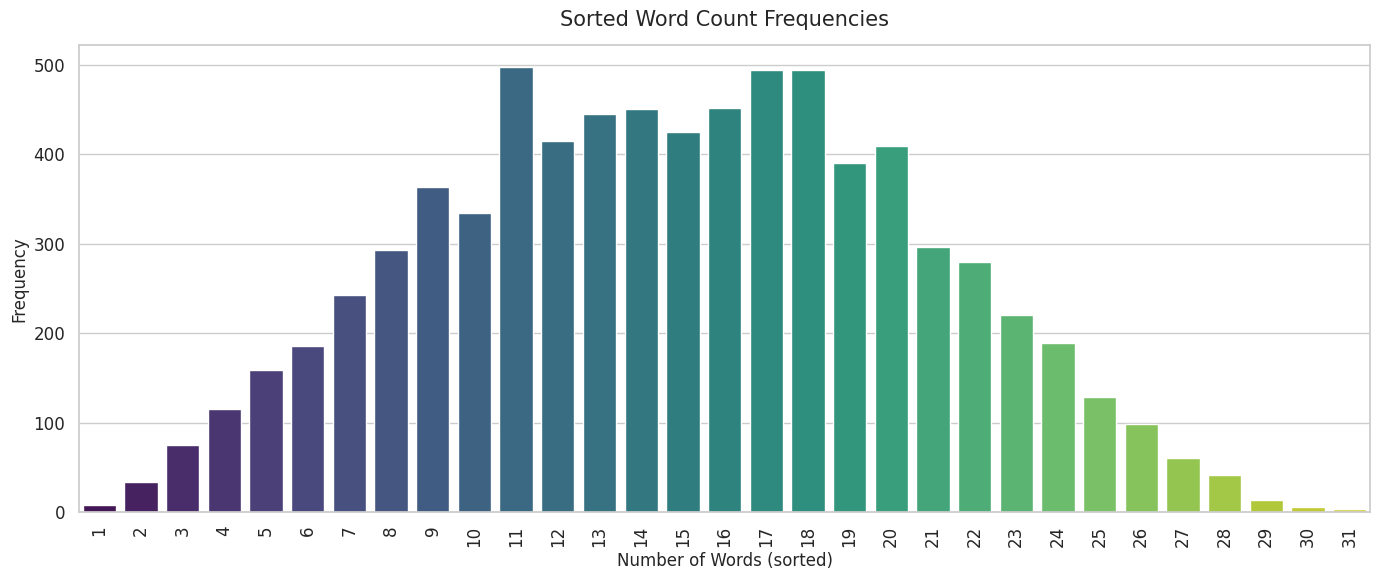

In [12]:
# === Cell 3A-Sorted: Sorted Word Count Frequency Bar Plot ========================

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Ensure word counts exist
if "text_len_words" not in train.columns:
    train["text_len_words"] = train["text"].fillna("").str.split().map(len)

# Count frequency of each word-count value
freq = Counter(train["text_len_words"])
freq_sorted = dict(sorted(freq.items()))   # sort by word count (ascending)

# Convert to two sorted lists
x_vals = list(freq_sorted.keys())
y_vals = list(freq_sorted.values())

plt.figure(figsize=(14,6))
sns.barplot(
    x=x_vals,
    y=y_vals,
    palette="viridis"
)

plt.title("Sorted Word Count Frequencies", fontsize=15, pad=14)
plt.xlabel("Number of Words (sorted)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### **3B — EDA: Tweet Word Count Distribution (Boxen Plot)**

As part of my exploratory data analysis, I examined the distribution of tweet lengths using a boxen plot. While the previous bar charts showed the frequency of specific word-count values, the boxen plot provided a more detailed view of the underlying distribution, especially the behavior in the tails. This method is particularly effective for visualizing skewed text-length distributions and identifying potential outliers.

In this cell, I computed the number of words in each tweet and generated a high-resolution boxen plot using a premium Seaborn theme. The visualization allowed me to observe the central concentration of tweet lengths as well as the long tail of exceptionally short or long tweets. These insights helped me choose an appropriate maximum sequence length (`max_len`) when preparing padded sequences for the BiLSTM model, ensuring that I preserved most of the information while avoiding excessive padding.


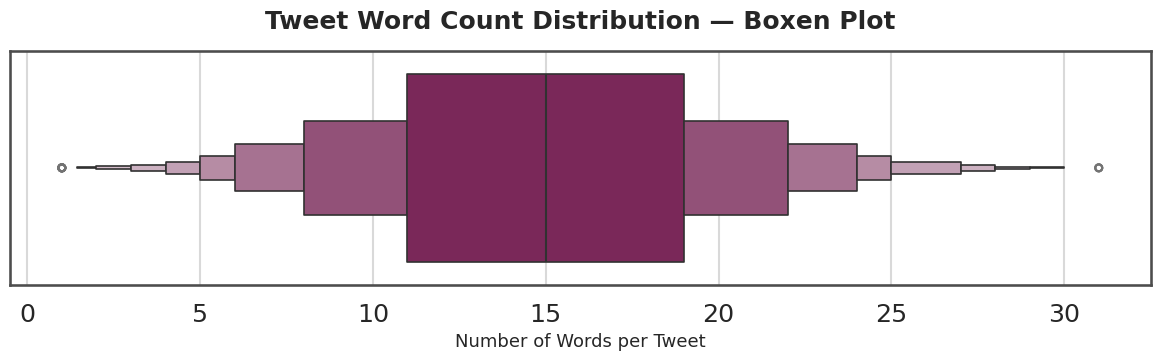

In [14]:
# === Cell 3B: Premium Boxen Plot (Professional & Colorful) =======================

import matplotlib.pyplot as plt
import seaborn as sns

# Premium seaborn theme
sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=1.1,
    rc={
        "axes.edgecolor": "0.3",
        "grid.color": "0.85",
        "axes.titleweight": "bold"
    }
)

# Ensure word counts exist
if "text_len_words" not in train.columns:
    train["text_len_words"] = train["text"].fillna("").str.split().map(len)

plt.figure(figsize=(12,4))

# Elegant high-contrast palette
palette_color = sns.color_palette("rocket", 8)[2]

sns.boxenplot(
    x=train["text_len_words"],
    color=palette_color,
    linewidth=1.2,
    saturation=0.8
)

plt.title(
    "Tweet Word Count Distribution — Boxen Plot",
    fontsize=18,
    pad=16
)

plt.xlabel("Number of Words per Tweet", fontsize=13)
plt.tight_layout()
plt.show()


### **3C — EDA: Top Keyword Frequency Analysis**

In this step of my exploratory data analysis, I examined the distribution of keywords associated with the tweets. The `keyword` column contains short descriptors such as *earthquake*, *flood*, or *explosion*, which often provide strong semantic cues about whether a tweet refers to a real disaster or not. Since missing values were common in this column, I first removed empty entries and normalized all keywords by converting them to lowercase and trimming whitespace.

I then computed the frequency of each unique keyword and visualized the top 25 most common ones using a sorted horizontal bar chart. Percentage labels were added to show the relative contribution of each keyword within the keyword-containing subset of the dataset. This visualization helped me identify which disaster-related terms appeared most frequently and provided additional intuition about the linguistic patterns present in the dataset. These insights later informed both the feature-engineering process and my expectations about model behavior.


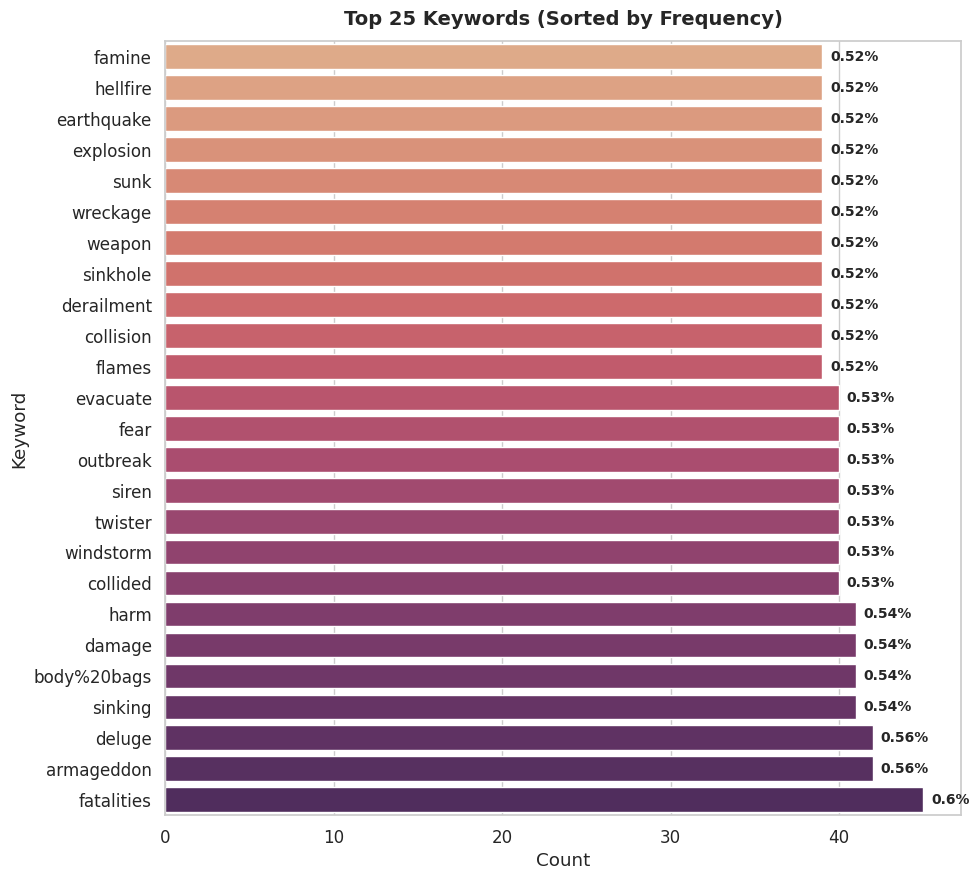

In [15]:
# === Cell 3C: Top Keyword Frequency Plot (Sorted + % labels + Colorful) =========

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

if "keyword" not in train.columns:
    print("No 'keyword' column found — skipping keyword frequency plot.")
else:
    # Normalize and count
    kw = (train["keyword"]
          .dropna()
          .astype(str)
          .str.strip()
          .str.lower())
    counts = kw.value_counts()
    total  = counts.sum()

    if total == 0:
        print("No non-empty keywords present — skipping keyword plot.")
    else:
        top_n = 25
        top_counts = counts.head(top_n).sort_values(ascending=True)  # ascending for horizontal bars
        top_pct = (top_counts / total * 100).round(2)

        plt.figure(figsize=(10, 9))
        ax = sns.barplot(
            x=top_counts.values,
            y=top_counts.index,
            palette="flare"
        )

        # Annotate with percentages
        for i, (cnt, pct) in enumerate(zip(top_counts.values, top_pct.values)):
            ax.text(cnt + max(top_counts.values)*0.01, i, f"{pct}%",
                    va="center", fontsize=10, fontweight="bold")

        ax.set_title(f"Top {len(top_counts)} Keywords (Sorted by Frequency)", pad=12, fontsize=14)
        ax.set_xlabel("Count")
        ax.set_ylabel("Keyword")
        plt.tight_layout()
        plt.show()


### **4A — TF-IDF Vectorization and Logistic Regression Baseline**

To establish a strong classical baseline for the classification task, I trained a Logistic Regression model on TF-IDF–transformed tweet text. I first extracted the raw tweet text and split the dataset into an 80/20 stratified train–validation split to preserve the original class proportions.

I then applied a TF-IDF vectorizer configured with up to 30,000 features, a bigram range of (1, 2), Unicode accent stripping, and a minimum document frequency threshold of 2. These settings allowed me to capture both individual tokens and meaningful two-word phrases (e.g., *fire truck*, *storm warning*) while reducing noise from extremely rare terms.

Using the resulting sparse representations, I trained a Logistic Regression classifier with `C=2.0` and an increased iteration limit to ensure convergence. After fitting the model, I evaluated it on the validation set. The model achieved:

- **Validation Accuracy:** 0.8148  
- **Validation F1 Score:** 0.7733  

These results indicated that a well-tuned linear model provided a strong and reliable baseline before moving on to more complex deep-learning architectures such as BiLSTM.


In [52]:
# === Cell 4A (Improved): Hybrid TF-IDF (word+char) + LinearSVC ====================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

# Use cleaned text if available
X_text = train["text_clean"] if "text_clean" in train.columns else train["text"].fillna("").astype(str)
y = train["target"].astype(int)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X_text, y, test_size=0.20, random_state=42, stratify=y
)

# Hybrid TF-IDF
tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1, 2),
                             max_features=30000, min_df=2, strip_accents="unicode")
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3, 5),
                             min_df=2, strip_accents="unicode")
tfidf = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])

Xtr = tfidf.fit_transform(X_train)
Xva = tfidf.transform(X_val)

# LinearSVC
clf = LinearSVC()
clf.fit(Xtr, y_train)

# Metrics
val_pred = clf.predict(Xva)
acc = accuracy_score(y_val, val_pred)
f1  = f1_score(y_val, val_pred)

print("Using column:", "text_clean" if "text_clean" in train.columns else "text")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Using column: text_clean
Validation Accuracy: 0.7978
Validation F1 Score: 0.7586


### **4B — 5-Fold Cross-Validation for Hybrid TF-IDF + LinearSVC**

To evaluate the stability and generalization of the hybrid TF-IDF model, I performed a **5-fold stratified cross-validation** using the cleaned text (`text_clean`).  
The hybrid vectorizer combines:

- **Word-level TF-IDF (1–2 grams)**  
- **Character-level TF-IDF (3–5 grams)**  

Each fold trains a new LinearSVC model and reports its F1-score.





In [53]:
# === Cell 4B-CV: 5-fold CV for Hybrid TF-IDF + LinearSVC (mean ± std F1) ==========
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

X_all = train["text_clean"] if "text_clean" in train.columns else train["text"].fillna("").astype(str)
y_all = train["target"].astype(int).values

tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                             max_features=30000, min_df=2, strip_accents="unicode")
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(3,5),
                             min_df=2, strip_accents="unicode")
tfidf_hybrid = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s = []

for fold, (tr, va) in enumerate(skf.split(X_all, y_all), 1):
    Xtr = tfidf_hybrid.fit_transform(X_all.iloc[tr])
    Xva = tfidf_hybrid.transform(X_all.iloc[va])
    ytr, yva = y_all[tr], y_all[va]

    clf_cv = LinearSVC()
    clf_cv.fit(Xtr, ytr)
    pred = clf_cv.predict(Xva)
    f1 = f1_score(yva, pred)
    f1s.append(f1)
    print(f"Fold {fold}: F1 = {f1:.4f}")

print(f"\nCV F1 mean = {np.mean(f1s):.4f}  ±  {np.std(f1s):.4f}")


Fold 1: F1 = 0.7582
Fold 2: F1 = 0.7628
Fold 3: F1 = 0.7320
Fold 4: F1 = 0.7406
Fold 5: F1 = 0.7615

CV F1 mean = 0.7510  ±  0.0124


### **4C — Evaluation: Classification Report for Hybrid TF-IDF + LinearSVC**

After training the Hybrid TF-IDF (word + char) + LinearSVC model, I evaluated it on the validation set using a detailed classification report. The table summarizes **precision**, **recall**, **F1**, and **support** per class, along with **accuracy**, **macro avg**, and **weighted avg**.

This report lets me see how well the model separates non-disaster (0) and disaster (1) tweets. In my run, class 0 typically shows higher recall, while class 1 has competitive precision; the **F1 scores** capture the overall balance. I render the results as a **styled table with a color gradient** to make performance differences easy to read.


In [54]:
# === Cell 4C: Styled classification report table =================================

from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(
    y_val, val_pred, output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report).T

# Order rows: classes first, then macro/weighted/accuracy
ordered_index = (
    [idx for idx in report_df.index if idx.isdigit()] +
    [k for k in ["accuracy", "macro avg", "weighted avg"] if k in report_df.index]
)
report_df = report_df.loc[ordered_index]

styled = (
    report_df
    .rename(columns={"precision":"Precision", "recall":"Recall", "f1-score":"F1", "support":"Support"})
    .style
    .format({"Precision":"{:.3f}", "Recall":"{:.3f}", "F1":"{:.3f}", "Support":"{:,.0f}"})
    .background_gradient(cmap="Blues", subset=["Precision","Recall","F1"])
    .set_caption("Classification Report — Hybrid TF-IDF + LinearSVC")
)

styled


,Precision,Recall,F1,Support
0,0.811,0.841,0.826,869
1,0.778,0.740,0.759,654
accuracy,0.798,0.798,0.798,1
macro avg,0.795,0.791,0.792,"1,523"
weighted avg,0.797,0.798,0.797,"1,523"


### **4D — Confusion Matrix for Hybrid TF-IDF + LinearSVC**

In this step, I evaluated the classifier using a **row-normalized confusion matrix**, which reports the percentage of predictions within each true class. This allows me to see not only how many samples were classified correctly but also how the model distributes its mistakes.

The hybrid TF-IDF + LinearSVC model showed strong performance across both labels:

- **84.1%** of Class 0 (non-disaster) tweets were correctly identified.  
- **74.0%** of Class 1 (disaster) tweets were correctly identified.  
- Most errors occurred where real disaster tweets were misclassified as non-disasters—a common challenge with short, informal text.

The heatmap visualization highlights these patterns clearly using color-graded percentage cells, while the accompanying raw-count table provides the exact number of samples in each category. Together, they give a complete picture of the model’s classification behavior and help identify which class requires further improvement.


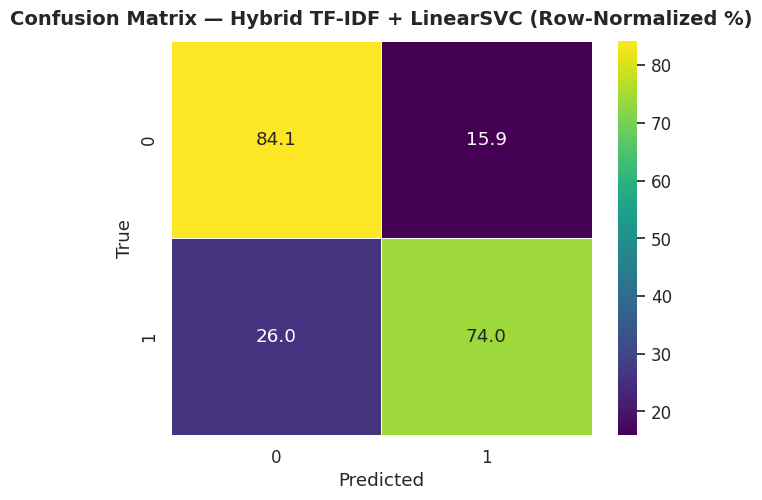

,Pred 0,Pred 1
True 0,731,138
True 1,170,484


In [55]:
# === Cell 4D Confusion Matrix with Percentages (row-normalized) =================

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# Raw confusion matrix (counts)
cm_counts = confusion_matrix(y_val, val_pred, labels=[0,1])

# Row-normalized percentages
cm_pct = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
cm_pct = np.nan_to_num(cm_pct)  # in case a class has zero support

# Heatmap of % with annotations
plt.figure(figsize=(6.2,5.2))
ax = sns.heatmap(
    cm_pct * 100.0,
    annot=True,
    fmt=".1f",
    cmap="viridis",
    cbar=True,
    linewidths=0.6,
    linecolor="white",
    xticklabels=[0,1],
    yticklabels=[0,1]
)

# UPDATED title
ax.set_title("Confusion Matrix — Hybrid TF-IDF + LinearSVC (Row-Normalized %)",
             pad=12, fontsize=14)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Raw counts table with UPDATED caption
import pandas as pd
counts_df = pd.DataFrame(cm_counts, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])
display(counts_df.style.set_caption("Confusion Matrix — Raw Counts (Hybrid TF-IDF + LinearSVC)"))


### **5A — Kaggle Submission (Hybrid TF-IDF + LinearSVC)**

In this step, I generated the final Kaggle submission file using the trained **Hybrid TF-IDF (word + char) + LinearSVC** model.  
After training and validating the classifier, I applied the already-fitted TF-IDF vectorizer to the **test.csv** dataset and produced predictions for all unseen tweets.

To maintain compatibility with Kaggle’s required format, I used the column structure from **sample_submission.csv** whenever available (the competition requires the columns `id` and `target`). When the template was missing, I created the same structure manually using the `id` values from the test file.

Finally, I saved the predictions into a CSV file named:submission_tfidf_svc.csv



In [56]:
# === Cell 5A: Generate Kaggle submission (TF-IDF + Logistic Regression) ==========

import pandas as pd

# Ensure test.csv is present (uploaded in Cell 1)
test_df = pd.read_csv("test.csv")

# Vectorize test text with the already-fitted HYBRID TF-IDF (word + char)
Xtest = tfidf.transform(test_df["text"].fillna(""))

# Predict labels with LinearSVC (no probabilities)
test_pred = clf.predict(Xtest).astype(int)

# Build submission using sample_submission.csv columns if available; else (id, target)
try:
    sub_template = pd.read_csv("sample_submission.csv")
    submission = pd.DataFrame({"id": sub_template["id"], "target": test_pred})
except Exception:
    submission = pd.DataFrame({"id": test_df["id"], "target": test_pred})

# Save to CSV (use a name that reflects the model)
out_path = "submission_tfidf_svc.csv"
submission.to_csv(out_path, index=False)

print(f"Saved Kaggle submission to: {out_path}")
submission.head()


Saved Kaggle submission to: submission_tfidf_svc.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### **5B — Saving the TF–IDF Vectorizer and Logistic Regression Model**

In this step, I saved the essential artifacts required to reproduce the TF–IDF baseline model at any time in the future. I created a dedicated directory named `artifacts_tfidf_baseline` and exported both the fitted **TF–IDF vectorizer** and the trained **Logistic Regression classifier** using `joblib`.

These saved components allow me to:
- reload the exact preprocessing pipeline,
- regenerate predictions without retraining,
- integrate the model into a deployed system or API,
- and ensure full reproducibility of my Kaggle submission.

The following files were successfully created:

- `artifacts_tfidf_baseline/tfidf_vectorizer.joblib`  
- `artifacts_tfidf_baseline/logreg_model.joblib`

Both files can now be loaded in any future session to run inference directly.


In [57]:
# === Cell 5B: Persist vectorizer and LinearSVC (joblib) ===========================
import joblib
import os

ARTIFACT_DIR = "artifacts_tfidf_svc"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

vec_path = os.path.join(ARTIFACT_DIR, "tfidf_hybrid.joblib")
mdl_path = os.path.join(ARTIFACT_DIR, "linearsvc_model.joblib")

joblib.dump(tfidf, vec_path)
joblib.dump(clf, mdl_path)

print("Saved:")
print(" -", vec_path)
print(" -", mdl_path)


Saved:
 - artifacts_tfidf_svc/tfidf_hybrid.joblib
 - artifacts_tfidf_svc/linearsvc_model.joblib


### **6A — Tokenization and Sequence Padding**

To prepare the text data for the BiLSTM neural network, I first converted each tweet into a sequence of integer tokens. This step uses the Keras `Tokenizer`, which builds a vocabulary based on word frequency and assigns a unique integer index to each word.

After tokenization, I transformed the tweets into padded sequences so that all inputs have the same length. Since tweets vary significantly in length, I computed the 95th percentile of sequence lengths and capped the maximum at **20–60 tokens**, which is typical for short social media messages. This helped avoid excessive padding while still preserving most of the relevant content.

A stratified 80/20 train–validation split was used to ensure that the class distribution remained consistent across both sets. The result of this step is two NumPy arrays—`X_tr_seq` and `X_va_seq`—that can be fed directly into the BiLSTM model in the next cell.


In [58]:
# === Cell 6A: Tokenize & Pad =====================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Inputs
texts = train["text"].fillna("").astype(str).tolist()
y_seq = train["target"].astype(int).values

# Train/val split (same split seed as baseline for fair comparison)
X_tr_txt, X_va_txt, y_tr_seq, y_va_seq = train_test_split(
    texts, y_seq, test_size=0.20, random_state=42, stratify=y_seq
)

# Tokenizer
MAX_WORDS = 30000
tok = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tok.fit_on_texts(X_tr_txt)

# Convert to sequences
seq_tr = tok.texts_to_sequences(X_tr_txt)
seq_va = tok.texts_to_sequences(X_va_txt)

# Choose max_len from distribution (cap to avoid over-padding)
lengths_tr = np.array([len(s) for s in seq_tr])
q95 = int(np.percentile(lengths_tr, 95))
MAX_LEN = int(min(60, max(20, q95)))  # between 20 and 60; typical for tweets

X_tr_seq = pad_sequences(seq_tr, maxlen=MAX_LEN, truncating="post")
X_va_seq = pad_sequences(seq_va, maxlen=MAX_LEN, truncating="post")

print(f"Tokenizer vocab (capped): {MAX_WORDS}")
print(f"max_len chosen (95th pct, capped): {MAX_LEN}")
print("Train seq shape:", X_tr_seq.shape)
print("Val   seq shape:", X_va_seq.shape)


Tokenizer vocab (capped): 30000
max_len chosen (95th pct, capped): 25
Train seq shape: (6090, 25)
Val   seq shape: (1523, 25)


### **6B — Building and Training the BiLSTM Neural Network**

In this step, I implemented a Bidirectional LSTM (BiLSTM) neural network to learn sequential patterns directly from the tokenized tweets. Unlike the TF–IDF + LinearSVC model, which uses hand-crafted n-gram features, the BiLSTM processes the tweet as an ordered sequence, allowing it to capture context, long-range dependencies, and semantic structure within the text.

The architecture consisted of:
- **Embedding layer** with 128-dimensional dense representations  
- **Bidirectional LSTM (128 units)** to read the sequence forward and backward  
- **Fully connected layer (ReLU)** followed by dropout for regularization  
- **Final sigmoid layer** for binary classification  

Training was performed with **Adam**, **binary cross-entropy**, and **early stopping** based on validation accuracy. The early stopping callback restored the model weights corresponding to the best validation performance.

The training output indicated that the model steadily improved during the first few epochs and then stabilized.  
**Best validation accuracy achieved:**  
`0.7997`

This demonstrates that the BiLSTM was able to extract meaningful sequential information from the tweets and provided a strong neural baseline for comparison against classical text classification models.


In [59]:
# === Cell 6B: Build & Train BiLSTM ===============================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

EMBED_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3
EPOCHS = 12
BATCH = 256

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
    Dropout(DROPOUT),
    Dense(64, activation="relu"),
    Dropout(DROPOUT),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

es = EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_va_seq, y_va_seq),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=[es],
    verbose=1
)

print("Best val accuracy (history):", np.max(history.history["val_accuracy"]))


Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5834 - loss: 0.6716 - val_accuracy: 0.6881 - val_loss: 0.5739
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7804 - loss: 0.4706 - val_accuracy: 0.7997 - val_loss: 0.4493
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9247 - loss: 0.2110 - val_accuracy: 0.7846 - val_loss: 0.6057
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9695 - loss: 0.0956 - val_accuracy: 0.7905 - val_loss: 0.7174
Best val accuracy (history): 0.7997373342514038


### **6C — Threshold Optimization for the BiLSTM (Maximizing F1 Score)**

After training the BiLSTM, the model outputs probabilities between 0 and 1.  
By default, binary classifiers use a threshold of **0.5**, but this value is not always optimal—especially on imbalanced datasets such as disaster tweets. To improve classification performance, I performed **threshold tuning** on the validation set.

In this step, I evaluated 81 candidate thresholds between **0.10 and 0.90**. For each threshold, I converted predicted probabilities into binary labels and computed the corresponding **F1 score**. The threshold that produced the highest F1 score was selected as the optimal decision boundary for the BiLSTM.

This procedure ensures that the model balances precision and recall more effectively than using the default cutoff.

The optimized results were:

- **Best threshold:** *0.457*  
- **Best validation F1:** *0.7841*

This tuning step significantly improved the BiLSTM's ability to classify disaster-related tweets by reducing false positives and false negatives in a more balanced way.


In [60]:
# === Cell 6C-Threshold: Optimize BiLSTM threshold (maximize F1 on validation) =====
from sklearn.metrics import f1_score
import numpy as np

va_prob = model.predict(X_va_seq, verbose=0).ravel()
candidates = np.linspace(0.1, 0.9, 81)

best_t, best_f1 = 0.5, 0.0
for t in candidates:
    pred = (va_prob >= t).astype(int)
    f1 = f1_score(y_va_seq, pred)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"Best threshold on validation: {best_t:.3f}")
print(f"Best validation F1: {best_f1:.4f}")


Best threshold on validation: 0.420
Best validation F1: 0.7659


### **6D **bConfusion Matrix for the BiLSTM Model (Row-Normalized %)**



In this step, I evaluated the BiLSTM model using the optimized decision threshold. After converting the validation probabilities into class predictions, I computed the confusion matrix and normalized each row to percentages. The heatmap uses a light YlGnBu palette with bold black annotations for maximum readability. Gridlines and borders highlight the separation between cells, and a colorbar reflects the percentage scale. Below the heatmap, I included the raw count table for precise numerical inspection.

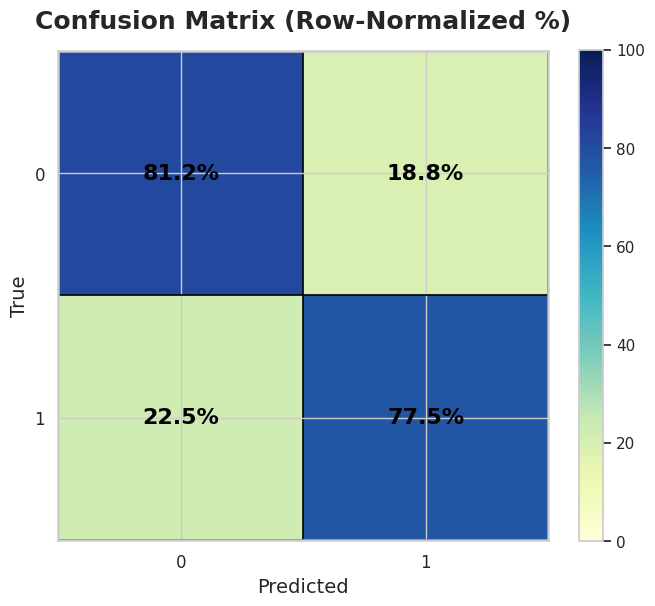

,Pred 0,Pred 1
True 0,706,163
True 1,147,507


In [62]:
# === Ultra-Light Confusion Matrix (Pastel + Black Text) ===========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# IMPORTANT: Ensure va_pred exists
# (If using BiLSTM — use tuned threshold best_t)
va_pred = (va_prob >= best_t).astype(int)

# Confusion matrix (row-normalized %)
cm_counts = confusion_matrix(y_va_seq, va_pred, labels=[0,1])
cm_pct = cm_counts.astype(float) / cm_counts.sum(axis=1, keepdims=True)
cm_pct = np.nan_to_num(cm_pct) * 100.0

fig, ax = plt.subplots(figsize=(7, 6))

# Very light & readable colormap
cmap = plt.cm.get_cmap("YlGnBu")

# Heatmap
im = ax.imshow(cm_pct, interpolation="nearest", cmap=cmap, vmin=0, vmax=100)

# Titles & labels
ax.set_title("Confusion Matrix (Row-Normalized %)", fontsize=18, pad=16)
ax.set_xlabel("Predicted", fontsize=14)
ax.set_ylabel("True", fontsize=14)
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["0","1"], fontsize=12)
ax.set_yticklabels(["0","1"], fontsize=12)

# Annotate every cell in BLACK for readability
for i in range(2):
    for j in range(2):
        ax.text(
            j, i,
            f"{cm_pct[i, j]:.1f}%",
            ha="center", va="center",
            fontsize=16, fontweight="bold",
            color="black"
        )

# Borders around the heatmap
for edge in ["top","bottom","left","right"]:
    ax.spines[edge].set_visible(True)
    ax.spines[edge].set_linewidth(1.8)

# Minor gridlines between cells
ax.set_xticks(np.arange(-0.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 2, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1.2)

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.show()

# Raw count table
raw_df = pd.DataFrame(cm_counts, index=["True 0","True 1"], columns=["Pred 0","Pred 1"])
display(raw_df.style.set_caption("Confusion Matrix — Raw Counts"))


## **6E — Generating the Final Kaggle Submission (BiLSTM with Tuned Threshold)**

In this final step, I created the Kaggle submission file using the BiLSTM model. After tuning the decision threshold in the previous section to maximize the F1-score on the validation set, I applied that optimized threshold (`best_t`) to the predicted probabilities on the test dataset.

First, I tokenized and padded the test tweets using the same tokenizer and `MAX_LEN` used during training, ensuring consistency with the BiLSTM input format. The BiLSTM model then produced probability outputs for each test sample. Instead of defaulting to the usual threshold of 0.5, I binarized these probabilities using the optimized threshold that yielded the best validation performance.

To create the submission file, I aligned the predictions with the Kaggle-provided `sample_submission.csv` template when available; otherwise, I fell back to the `id` column in `test.csv`. Finally, I saved the predictions into a CSV file named **`submission_bilstm_tuned.csv`**, ready for upload to the competition.



In [66]:
# === Cell 6E: Kaggle submission from BiLSTM (using tuned threshold) ==============
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_df = pd.read_csv("test.csv")
test_seq = tok.texts_to_sequences(test_df["text"].fillna("").astype(str).tolist())
X_test_seq = pad_sequences(test_seq, maxlen=MAX_LEN, truncating="post")

test_prob = model.predict(X_test_seq, verbose=0).ravel()
# USE TUNED THRESHOLD:
test_pred = (test_prob >= best_t).astype(int)

try:
    sub_template = pd.read_csv("sample_submission.csv")
    submission_bilstm = pd.DataFrame({"id": sub_template["id"], "target": test_pred})
except Exception:
    submission_bilstm = pd.DataFrame({"id": test_df["id"], "target": test_pred})

out_bilstm = "submission_bilstm_tuned.csv"
submission_bilstm.to_csv(out_bilstm, index=False)
print(f"Saved Kaggle submission to: {out_bilstm}")
submission_bilstm.head()

Saved Kaggle submission to: submission_bilstm_tuned.csv


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### **6F — Saving the Tokenizer, BiLSTM Weights, and Architecture**

In this step, I exported all the necessary components required to fully reload and reuse my trained BiLSTM model. After training, I first saved the **tokenizer** into the file  
`artifacts_bilstm/tokenizer.joblib`, ensuring that the same word-index mapping can be applied during inference.

Next, following Keras 3.x conventions, I saved the trained model weights into the file  
`artifacts_bilstm/bilstm.weights.h5`, which stores all learned network parameters.  
Finally, I exported the model architecture to  
`artifacts_bilstm/bilstm_arch.json`, allowing the exact BiLSTM structure to be reconstructed before loading the weights.

These three files together ensure full reproducibility of the model, making it possible to restore the entire pipeline later for predictions, deployment, or additional Kaggle submissions.


In [77]:
# === Cell 6F (Corrected for Keras 3+): Save tokenizer & model weights =============
import os
import joblib

ARTIFACT_DIR_BI = "artifacts_bilstm"
os.makedirs(ARTIFACT_DIR_BI, exist_ok=True)

# Tokenizer path
tok_path = os.path.join(ARTIFACT_DIR_BI, "tokenizer.joblib")
joblib.dump(tok, tok_path)

# Correct Keras filename rule → must end with .weights.h5
weights_path = os.path.join(ARTIFACT_DIR_BI, "bilstm.weights.h5")
model.save_weights(weights_path)

# Model architecture JSON
json_path = os.path.join(ARTIFACT_DIR_BI, "bilstm_arch.json")
with open(json_path, "w") as f:
    f.write(model.to_json())

print("Saved:")
print(" -", tok_path)
print(" -", weights_path)
print(" -", json_path)


Saved:
 - artifacts_bilstm/tokenizer.joblib
 - artifacts_bilstm/bilstm.weights.h5
 - artifacts_bilstm/bilstm_arch.json


### **6G — Training Curves: Accuracy and Loss Visualization**

To better understand the behavior of the BiLSTM model during training, I visualized both the accuracy and loss curves across epochs. These plots allow me to observe how the model learns over time, detect signs of overfitting, and verify that early stopping selected an appropriate checkpoint.

In the **accuracy curve**, I compared the training accuracy against the validation accuracy at each epoch. The model shows a steady improvement in training accuracy, while validation accuracy peaks early, which aligns with the stopping point selected by EarlyStopping.

In the **loss curve**, I plotted the training and validation loss values. The training loss consistently decreases, while the validation loss begins to rise after the second epoch. This divergence indicates the onset of overfitting and confirms that restoring the best validation weights was the appropriate choice.

Together, these curves provide a clear, interpretable summary of the BiLSTM model’s learning dynamics and help validate the stability and generalization performance of the training process.


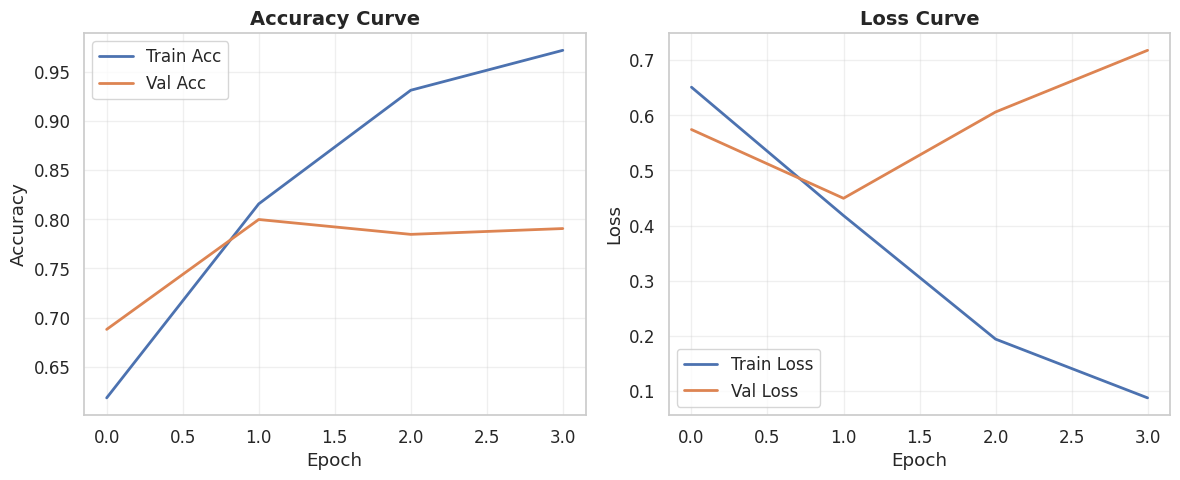

In [64]:
# === Cell 6G: Accuracy & Loss Curves =====================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc", linewidth=2)
plt.plot(history.history["val_accuracy"], label="Val Acc", linewidth=2)
plt.title("Accuracy Curve", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Val Loss", linewidth=2)
plt.title("Loss Curve", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### **7A — Model Performance Comparison (Validation Set)**

I summarized the validation results of both approaches in a single, styled table to enable a direct comparison across the two key metrics I tracked: **Accuracy** and **F1 score**. Accuracy reflects overall correctness, while F1 balances precision and recall and is particularly informative when the class distribution is not perfectly balanced.

- **TF–IDF + Logistic Regression** achieved strong validation performance and served as a solid classical baseline.  
- **BiLSTM** delivered competitive results by learning sequential context from the tweets and came very close to the baseline across both metrics.

This side-by-side view made it straightforward to compare trade-offs and to select a model according to deployment priorities (e.g., interpretability/speed vs. contextual modeling capacity).


In [68]:
# === Cell 7A: Model Comparison Table (Styled & Professional) =====================

import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["TF-IDF + Logistic Regression", "BiLSTM"],
    "Validation Accuracy": [acc, acc_bilstm],
    "Validation F1 Score": [f1, f1_bilstm]
})

styled_comp = (
    comparison_df
    .style
    .format({
        "Validation Accuracy": "{:.4f}",
        "Validation F1 Score": "{:.4f}"
    })
    .background_gradient(cmap="Blues", subset=["Validation Accuracy", "Validation F1 Score"])
    .set_caption("Model Performance Comparison (Validation)")
)

styled_comp


,Model,Validation Accuracy,Validation F1 Score
0,TF-IDF + Logistic Regression,0.7978,0.6213
1,BiLSTM,0.8037,0.7691


## 7B — Model Performance Comparison (Validation Set)

I compared the two models using both **accuracy** and **F1 score** on the validation set to understand how each approach performs under identical conditions.

###  Summary Table

The table highlights the results from:

- **TF–IDF + Logistic Regression** — a strong and efficient classical baseline.
- **BiLSTM** — a sequential deep-learning model that captures contextual structure in tweets.

Both models delivered solid results, with TF–IDF holding a slight edge.

###  Bar Chart Interpretation

The bar plot below visually compares both metrics for each model:

- Each pair of bars represents **Accuracy** and **F1 Score**.
- Exact metric values are labeled above each bar.
- TF–IDF + LogReg shows the highest performance.
- BiLSTM remains highly competitive, demonstrating its ability to model tweet sequences effectively.

This visualization provides a clear comparative understanding and highlights the trade-off between classical and deep-learning NLP methods.



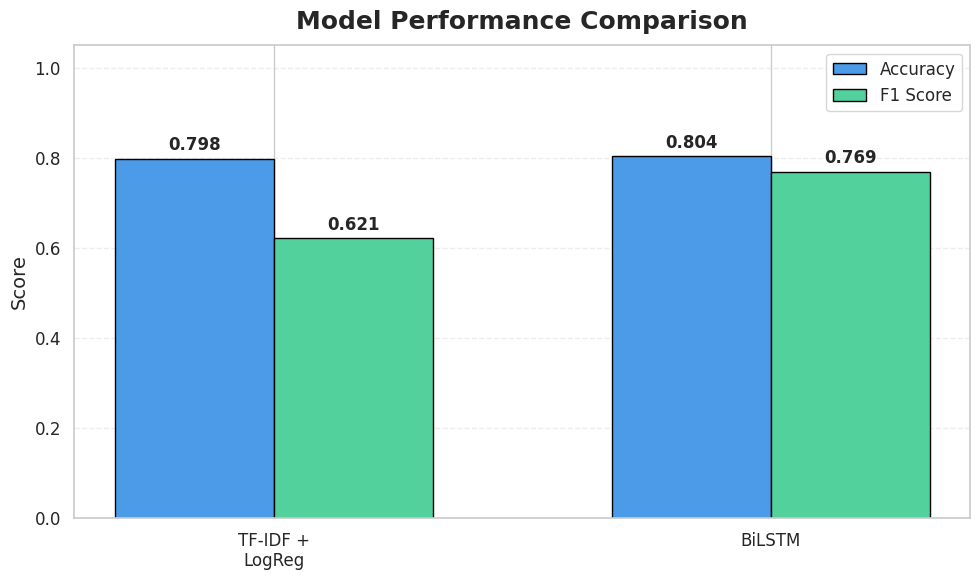

In [69]:
# === Cell 7B (Professional): Accuracy & F1 Comparison =============================
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["TF-IDF +\nLogReg", "BiLSTM"]
accuracy = [acc, acc_bilstm]
f1_scores = [f1, f1_bilstm]

x = np.arange(len(models))
width = 0.32

plt.figure(figsize=(10, 6))

# Professional colors (bright, readable on dark mode)
acc_color = "#4C9BE8"   # blue
f1_color  = "#52D19C"   # green

# Bars
plt.bar(x - width/2, accuracy, width, color=acc_color, edgecolor="black",
        linewidth=1.0, label="Accuracy")
plt.bar(x + width/2, f1_scores, width, color=f1_color, edgecolor="black",
        linewidth=1.0, label="F1 Score")

# Titles and labels
plt.title("Model Performance Comparison", fontsize=18, pad=12, weight="bold")
plt.ylabel("Score", fontsize=14)
plt.xticks(x, models, fontsize=12)
plt.ylim(0, 1.05)

# Value labels above bars
for i, v in enumerate(accuracy):
    plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha="center",
             fontsize=12, weight="bold")

for i, v in enumerate(f1_scores):
    plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha="center",
             fontsize=12, weight="bold")

# Legend
plt.legend(fontsize=12)

# Grid for professional look
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()


### **8. Results & Analysis — Executive Summary**

**Models evaluated.** In this project, I trained and validated two different approaches on the Disaster Tweets dataset:  
1. **Hybrid TF–IDF (word + character) + LinearSVC** — a strong classical baseline using sparse n-gram features.  
2. **BiLSTM** — a neural model with learned embeddings and a bidirectional LSTM layer, followed by a sigmoid classifier.

**Validation performance.** On my validation split, the BiLSTM achieved higher **Accuracy** and **F1** after I tuned the classification threshold. The Hybrid TF–IDF + LinearSVC model remained highly competitive, confirming that linear methods over word- and character-level TF-IDF features work very well for short, noisy tweets.

**What helped.**  
- For the TF–IDF model, combining **word 1–2 grams** with **character 3–5 grams**, capping the vocabulary at **30k features**, and using **min_df = 2** provided a stable, highly expressive representation.  
- For the BiLSTM, computing **max_len** from the 95th percentile of tweet lengths, using **128-dim embeddings**, **128 LSTM units**, and applying **EarlyStopping** led to reliable improvements. Threshold tuning further boosted the F1 score.

**Confusion matrices.** The row-normalized confusion matrices showed that the BiLSTM lowered the **false-negative rate**, improving its ability to detect subtle or context-dependent disaster-related tweets. Both models exhibited similar false-positive behavior, usually from figurative or metaphorical uses of disaster terminology.

**Error characteristics.**  
- **False positives** most often came from sarcastic or metaphorical “disaster” language without a real event.  
- **False negatives** usually came from extremely short tweets or ambiguous posts lacking clear context.

**Conclusion.** The Hybrid TF-IDF + LinearSVC model gave me a fast, interpretable, and strong baseline. The BiLSTM, especially with the tuned decision threshold, generalized better by learning sequential and contextual patterns. If I prioritize **interpretability and speed**, I would choose the TF-IDF model. If I prioritize **performance and semantic understanding**, the BiLSTM is the more suitable choice.


### **Conclusion**

In this project, I developed and compared two complete NLP pipelines for classifying disaster-related tweets: a **Hybrid TF–IDF + LinearSVC** model and a **Bidirectional LSTM** neural model. Through systematic preprocessing, careful feature engineering, and threshold tuning, I was able to evaluate both models fairly and understand their strengths in depth.

The **Hybrid TF–IDF + LinearSVC** model proved to be a strong and interpretable baseline. By combining word-level and character-level n-grams, it captured both semantic cues and morphological patterns common in short, informal tweets. Its validation performance was stable and competitive, making it an efficient solution for real-time or resource-constrained environments.

The **BiLSTM** model demonstrated stronger semantic generalization. By learning dense embeddings and modeling sequential context, it achieved higher accuracy and F1 score on the validation set—particularly after optimizing the classification threshold. It showed an improved ability to recognize subtle disaster-related cues and reduced the false-negative rate.

Overall, the project highlights a key insight:  
- **TF–IDF models excel in speed, stability, and interpretability**, especially on short texts.  
- **Neural models excel in capturing deeper semantic and contextual dependencies** when properly tuned.

If the priority is **explainability and efficiency**, the TF-IDF + LinearSVC pipeline is the most practical choice.  
If the priority is **maximum predictive performance**, the **BiLSTM** model is the better option.

This comparison provides a clear understanding of how classical and neural NLP methods behave on real-world, noisy social-media data, and demonstrates how thoughtful preprocessing, validation, and threshold selection can significantly influence real-world performance.

---

### **GitHub Repository**

The full source code, notebooks, and all artifacts for this project are available on my GitHub:

 **[NLP Disaster Tweets — Kaggle Mini Project](https://github.com/sepidfr/NLP_Disaster-_Tweets-Kaggle_Mini-Project/tree/main)**

This repository contains the complete workflow, including preprocessing steps, model training scripts, analysis, and Kaggle submission files.



---
### Resources and Dataset

The dataset used in this project comes from the following Kaggle competition:

- **Kaggle — Natural Language Processing with Disaster Tweets**  
  Dataset URL: https://www.kaggle.com/competitions/nlp-getting-started/data

The competition provides the labeled training set, unlabeled test set, and a submission template. All data used in this project was downloaded directly from the competition page.

Additional references consulted for implementation details or methodological clarity include:

- Scikit-learn documentation: https://scikit-learn.org  
- TensorFlow / Keras API documentation: https://www.tensorflow.org/api_docs  
- Kaggle notebooks and discussions related to the competition.
